## Generative Adversarial Network: A Guide Using Fashion MNIST

In [1]:
# Tensorflow warning logging: OFF
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# Generic libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Machine learning
import tensorflow as tf
import keras

# Layers
from tensorflow.keras.layers import (Dense, Flatten, Reshape)

# Fashion MNIST dataset
from tensorflow.keras.datasets import fashion_mnist

# Others
from tensorflow.keras import Input

print(tf.__version__)

2.15.0


### Fashion MNIST Loading

In [3]:
# Load Fashion MNIST
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
# Display information about the dataset
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [5]:
# Define the input shape of the images and the number of classes
num_classes = 10
img_rows, img_cols = 28, 28

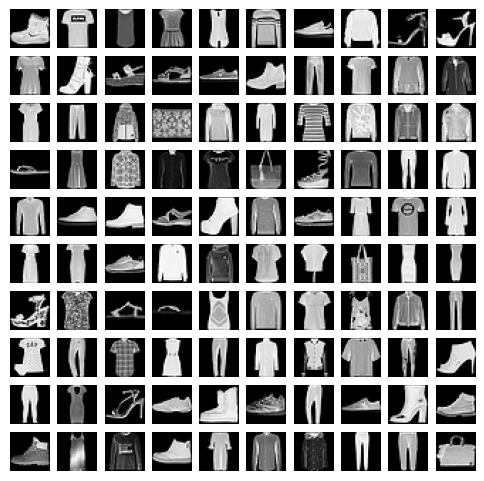

In [6]:
# Show grid of 10x10 images
fig, ax = plt.subplots(10, 10, figsize=(6,6))
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(train_images[i*10+j], cmap='gray')
        ax[i,j].axis('off')
plt.show()

### Data Pre-Processing

In [7]:
# Normalize the data
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [8]:
# Print shape of the dataset
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")

Train images shape: (60000, 28, 28)
Test images shape: (10000, 28, 28)


In [9]:
# Reshape the images to add the mono channel dimension (1)
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)

In [10]:
# Convert class vectors to binary class matrices
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

In [11]:
# Print shape of the labels
print(f"Train labels shape: {train_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train labels shape: (60000, 10)
Test labels shape: (10000, 10)


### Defining: GAN Model

In [12]:
codings_size = 30

In [13]:
generator = keras.models.Sequential([
    Dense(100, activation="selu", input_shape=[codings_size]),
    Dense(150, activation="selu"),
    Dense(28 * 28, activation="sigmoid"),
    Reshape([28, 28])
])

discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    Dense(150, activation="selu"),
    Dense(100, activation="selu"),
    Dense(1, activation="sigmoid"),
])

gan = keras.models.Sequential([generator, discriminator])

### Compiling: GAN Model

In [14]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

### Dataset Preparation

In [30]:
batch_size = 52
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

### GAN Training

In [35]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))             
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                    
        plt.show()                                                  


In [36]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Epoch 1/1


InvalidArgumentError: {{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Ranks of all input tensors should match: shape[0] = [52,28,28] vs. shape[1] = [52,28,28,1] [Op:ConcatV2] name: concat